# Extracting Information from Scores and Performances

For many MIR tasks we need to extract specific information out of scores or performances. 
Two of the most common representations are **note arrays** and **piano rolls**. 

**Note that there is some overlap in the way that these terms are used.**

Partitura provides convenience methods to extract these common features in a few lines!

In [1]:
import partitura as pt
import numpy as np
import matplotlib.pyplot as plt

## Note Arrays

A **note array** is a 2D array in which each row represents a note in the score/performance and each column represents different attributes of the note.

In partitura, note arrays are [structured numpy arrays](https://numpy.org/devdocs/user/basics.rec.html), which are ndarrays in which each "column" has a name, and can be of different datatypes. 
This allows us to hold information that can be represented as integers (MIDI pitch/velocity), floating point numbers (e.g., onset time) or strings (e.g., note ids). 

In this tutorial we are going to cover 3 main cases

* Getting a note array from `Part` and `PerformedPart` objects
* Extra information and alternative ways to generate a note array
* Creating a custom note array from scratch from a `Part` object


### 1. Getting a note array from `Part` and `PerformedPart` objects

#### Getting a note array from `Part` objects

In [2]:
# Note array from a score

# Path to the MusicXML file
score_fn = '../data/musicxml/Chopin_op10_no3.musicxml'

# Load the score into a `Part` object
score_part = pt.load_musicxml(score_fn)

# Get note array.
score_note_array = score_part.note_array

It is that easy!

In [3]:
# Lets see the first notes in this note array
print(score_note_array[:5])

[(-0.5, 0.5 , -0.5, 0.5 , 0,  8, 59, 1, 'n1')
 ( 0. , 0.25,  0. , 0.25, 8,  4, 40, 4, 'n4voice_overlap')
 ( 0. , 1.  ,  0. , 1.  , 8, 16, 40, 7, 'n4')
 ( 0. , 0.25,  0. , 0.25, 8,  4, 56, 3, 'n3')
 ( 0. , 0.5 ,  0. , 0.5 , 8,  8, 64, 1, 'n2')]


By default, Partitura includes some of the most common note-level information in the note array:

In [4]:
print(score_note_array.dtype.names)

('onset_beat', 'duration_beat', 'onset_quarter', 'duration_quarter', 'onset_div', 'duration_div', 'pitch', 'voice', 'id')


* `onset_beat` is the onset time in beats (as indicated by the time signature).
* `duration_beat` is the duration of the note in beats
* `onset_quarter` is the onset time of the note in quarters (independent of the time signature)
* `duration_quarter`is the duration of the note in quarters
* `onset_div` is the onset of the note in *divs*, which is generally a number that allows to represent the note position and duration losslessly with integers. 
* `duration_div` is the duration of the note in divs.
* `pitch` is the MIDI pitch (MIDI note number) of the note
* `voice` is the voice of the note (in polyphonic music, where there can be multiple notes at the same time)
* `id` is the note id (as appears in MusicXML or MEI formats)

#### Getting a note array from a  `PerformedPart`

In a similar way, we can obtain a note array from a MIDI file in a few lines

In [5]:
# Note array from a performance

# Path to the MIDI file
performance_fn = '../data/midi/Chopin_op10_no3_p01.mid'

# Loading the file to a PerformedPart
performance_part = pt.load_performance_midi(performance_fn)

# Get note array!
performance_note_array = performance_part.note_array

Since performances contain have other information not included in scores, the default fields in the note array are a little bit different:

In [6]:
print(performance_note_array.dtype.names)

('onset_sec', 'duration_sec', 'pitch', 'velocity', 'track', 'channel', 'id')


* `onset_sec` is the onset time of the note in seconds
* `duration_sec` is the duration of the note in seconds
* `pitch` is the MIDI pitch
* `velocity` is the MIDI velocity
* `track` is the track number in the MIDI file
* `channel` is the channel in the MIDI file
* `id` is the ID of the notes (automatically generated for MIDI file according to onset time)

In [7]:
print(performance_note_array[:5])

[(4.9925 , 0.8775 , 59, 44, 1, 0, 'n0')
 (5.7025 , 2.4375 , 40, 22, 1, 0, 'n1')
 (5.70375, 2.43625, 64, 54, 1, 0, 'n2')
 (5.77625, 2.36375, 56, 26, 1, 0, 'n3')
 (6.4325 , 1.7075 , 47, 20, 1, 0, 'n4')]


We can also create a `PerformedPart` directly from a note array

In [8]:
note_array = np.array(
    [(60, 0, 2, 40),
     (65, 0, 1, 15),
     (67, 0, 1, 72),
     (69, 1, 1, 90),
     (66, 2, 1, 80)],
    dtype=[("pitch", "i4"),
           ("onset_sec", "f4"),
           ("duration_sec", "f4"),
           ("velocity", "i4"),
          ]
)

# Note array to `PerformedPart`
performed_part = pt.performance.PerformedPart.from_note_array(note_array)

We can then export the `PerformedPart` to a MIDI file!

In [9]:
# export as MIDI file
pt.save_performance_midi(performed_part, "example.mid")

### 2. Extra information and alternative ways to generate a note array

Sometimes we require more information in a note array.

In [10]:
extended_score_note_array = pt.utils.music.ensure_notearray(
    score_part,
    include_pitch_spelling=True,
    include_key_signature=True,
    include_time_signature=True,
    include_metrical_position=True,
    include_grace_notes=True
)

In [11]:
extended_score_note_array.dtype.names

('onset_beat',
 'duration_beat',
 'onset_quarter',
 'duration_quarter',
 'onset_div',
 'duration_div',
 'pitch',
 'voice',
 'id',
 'step',
 'alter',
 'octave',
 'is_grace',
 'grace_type',
 'ks_fifths',
 'ks_mode',
 'ts_beats',
 'ts_beat_type',
 'is_downbeat',
 'rel_onset_div',
 'tot_measure_div')

In [12]:
print(extended_score_note_array[['onset_beat', 
                                 'step', 
                                 'alter', 
                                 'octave', 
                                 'ks_fifths', 
                                 'ks_mode',
                                 'is_downbeat']][:10])

[(-0.5 , 'B', 0, 3, 4, 1, 0) ( 0.  , 'E', 0, 2, 4, 1, 1)
 ( 0.  , 'E', 0, 2, 4, 1, 1) ( 0.  , 'G', 1, 3, 4, 1, 1)
 ( 0.  , 'E', 0, 4, 4, 1, 1) ( 0.25, 'B', 0, 2, 4, 1, 0)
 ( 0.25, 'B', 0, 3, 4, 1, 0) ( 0.5 , 'G', 1, 3, 4, 1, 0)
 ( 0.5 , 'D', 1, 4, 4, 1, 0) ( 0.75, 'B', 0, 2, 4, 1, 0)]


### 3. Creating a custom note array from scratch from a `Part` object

Sometimes we are interested in other note-level information that is not included in the standard note arrays. 
With partitura we can create such a note array easily!

For example, imagine that we want a note array that includes whether the notes have an accent mark.

In [13]:
def get_accent_note_array(part):
    
    fields = [("onset_beat", "f4"), 
              ("pitch", "i4"),
              ("accent", "i4")]
    # Get all notes in the part
    notes = part.notes_tied
    # Beat map (maps divs to score time in beats)
    beat_map = part.beat_map
    N = len(notes)
    note_array = np.zeros(N, dtype=fields)
    for i, n in enumerate(notes):
        # MIDI pitch
        note_array[i]['pitch'] = n.midi_pitch
        # Get the onset time in beats
        note_array[i]['onset_beat'] = beat_map(n.start.t)
        
        # Iterate over articulations in the note
        if n.articulations:
            for art in n.articulations:
                if art == 'accent':
                    note_array[i]['accent'] = 1
    return note_array

accent_note_array = get_accent_note_array(score_part)

accented_note_idxs = np.where(accent_note_array['accent'])
print(accent_note_array[accented_note_idxs])

[( 0.25, 47, 1) ( 1.25, 47, 1) ( 2.25, 47, 1) ( 3.  , 68, 1)
 ( 3.25, 47, 1) ( 4.25, 47, 1) ( 5.25, 47, 1) ( 6.25, 47, 1)
 ( 7.  , 66, 1) ( 7.25, 47, 1) ( 8.25, 47, 1) ( 9.25, 47, 1)
 (10.25, 52, 1) (11.25, 52, 1) (12.25, 54, 1) (13.25, 54, 1)
 (14.25, 54, 1) (15.25, 54, 1) (16.25, 47, 1) (17.25, 47, 1)
 (18.25, 47, 1) (19.25, 47, 1) (20.25, 47, 1) (21.25, 47, 1)
 (22.25, 47, 1) (23.25, 47, 1) (24.25, 47, 1) (25.25, 47, 1)
 (26.25, 52, 1) (27.25, 52, 1) (28.25, 56, 1) (29.25, 56, 1)
 (32.  , 80, 1)]


## Piano rolls


### Extracting a piano roll

In [14]:
# TODO: change the example
# Path to the MusicXML file
score_fn = '../data/musicxml/Chopin_op10_no3.musicxml'

# Load the score into a `Part` object
score_part = pt.load_musicxml(score_fn)
pianoroll = pt.utils.compute_pianoroll(score_part)

The `compute_pianoroll` method has a few arguments to customize the resulting piano roll

In [15]:
piano_range = True
time_unit = 'beat'
time_div = 10
pianoroll = pt.utils.compute_pianoroll(
    note_info=score_part, # a `Part`, `PerformedPart` or a note array
    time_unit=time_unit, # beat, quarter, div, sec, etc. (depending on note_info)
    time_div=time_div, # Number of cells per time unit
    piano_range=piano_range # Use range of the piano (88 keys)
)

An important thing to remember is that in piano rolls generated by `compute_pianoroll`, rows (the vertical axis) represent the pitch dimension and the columns (horizontal) the time dimension. 
This results in a more intuitive way of plotting the piano roll. 
For other applications the transposed version of this piano roll might be more useful (i.e., rows representing time steps and columns representing pitch information).

Since piano rolls can result in very large matrices where most of the elements are 0, the output of `compute_pianoroll` is a [scipy sparse matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html). To convert it to a regular numpy array, we can simply use `pianoroll.toarray()`

Let's plot the piano roll!

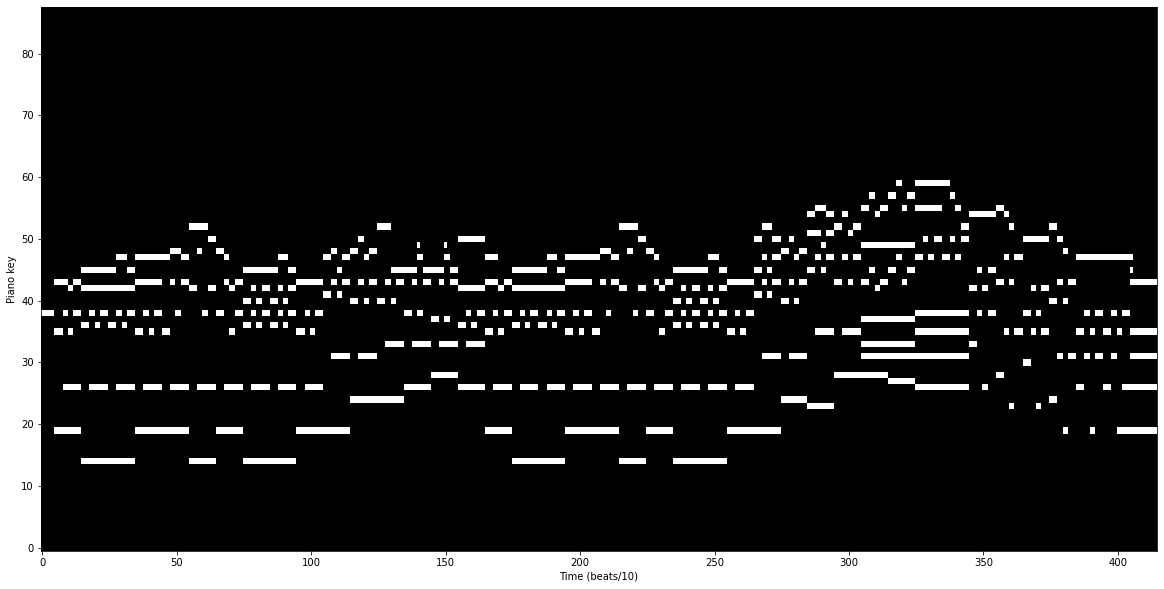

In [16]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(pianoroll.toarray(), origin="lower", cmap='gray', interpolation='nearest', aspect='auto')
ax.set_xlabel(f'Time ({time_unit}s/{time_div})')
ax.set_ylabel('Piano key' if piano_range else 'MIDI pitch')
plt.show()

In some cases, we want to know the "coordinates" of each of the notes in the piano roll. The `compute_pianoroll` method includes an option to return 

In [17]:
pianoroll, note_indices = pt.utils.compute_pianoroll(score_part, return_idxs=True)

# MIDI pitch, start, end
print(note_indices[:5])

[[59  0  4]
 [40  4  6]
 [40  4 12]
 [56  4  6]
 [64  4  8]]


### Generating a note array from a piano roll

Partitura also includes a method to generate a note array from a piano roll, which can be used to generate a MIDI file. 
This method would be useful, e.g., for music generation tasks

In [18]:
pianoroll = pt.utils.compute_pianoroll(score_part)

new_note_array = pt.utils.pianoroll_to_notearray(pianoroll)

# We can export the note array to a MIDI file
ppart = pt.performance.PerformedPart.from_note_array(new_note_array)

pt.save_performance_midi(ppart, "newmidi.mid")

# Handling Alignment Information (Matchfiles)

## Loading Alignments
An important use case of partitura is to handle symbolic alignment information

**Note that partitura itself does not contain methods for alignment**

Partitura supports 2 formats for encoding score-to-performance alignments

* The Match format, introduced by Gerhard et al.,
* The format 

Let's load an alignment!

We have two common use cases

* We have both the match file and the symbolic score file (e.g., MusicXML or MEI)
* We have only the match file

#### 1. Loading an alignment if we have both score and match files

This should be the preferred way to get alignment information

In [19]:
# path to the score in MusicXML

# path to the match
match_fn = '../data/match/Chopin_op10_no3_p01.match'
# Path to the MusicXML file
score_fn = '../data/musicxml/Chopin_op10_no3.musicxml'
# Load the score into a `Part` object
score_part = pt.load_musicxml(score_fn)

# loading a match file
performed_part, alignment = pt.load_match(match_fn)

Score-to-performance alignments are represented by lists of dictionaries that contain information

* `'match'`: there is a performed note corresponding to a score note
* `'insertion'`: the performed note does not correspond to any note in the score
* `'deletion'`: there is no performed note corresponding to a note in the score
* `'ornament'`: the performed note corresponds to the performance of an ornament (e.g., a trill)

In [20]:
alignment[:10]

[{'label': 'match', 'score_id': 'n1', 'performance_id': 0},
 {'label': 'match', 'score_id': 'n2', 'performance_id': 2},
 {'label': 'match', 'score_id': 'n3', 'performance_id': 3},
 {'label': 'match', 'score_id': 'n4', 'performance_id': 1},
 {'label': 'match', 'score_id': 'n5', 'performance_id': 5},
 {'label': 'match', 'score_id': 'n6', 'performance_id': 4},
 {'label': 'match', 'score_id': 'n7', 'performance_id': 6},
 {'label': 'match', 'score_id': 'n8', 'performance_id': 7},
 {'label': 'match', 'score_id': 'n9', 'performance_id': 8},
 {'label': 'match', 'score_id': 'n10', 'performance_id': 9}]

#### 2. Loading an alignment if we only have a match file

Match files contain a complete information included in performances in MIDI files.

A useful property of match files is that they include information about the **score and the performance**.
It is important to note that the score information included in a match file is not necessarily complete.
For example, match files do not include dynamics or tempo markings.
They do include however, full information about pitch spelling and score position and duration of the notes, as well as time and key signature information.

Therefore, it is possible to create both a  `Part` and a `PerformedPart` from a match file. 

In [21]:
# loading a match file
performed_part, alignment, score_part = pt.load_match(match_fn, create_part=True)

## Getting information from the alignments

Partitura includes a few methods for getting information from the alignments

In [22]:
snote_array = score_part.note_array
pnote_array = performed_part.note_array
matched_note_idxs = pt.utils.music.get_matched_notes(snote_array, pnote_array, alignment)
matched_snote_array = snote_array[matched_note_idxs[:, 0]]
matched_pnote_array = pnote_array[matched_note_idxs[:, 1]]

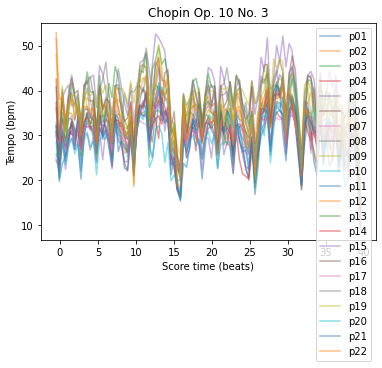

In [32]:
import glob
import os

match_dir = '../data/match'
matchfiles = glob.glob(os.path.join(match_dir, 'Chopin_op10_no3_p*.match'))
matchfiles.sort()

score_time = np.linspace(snote_array['onset_beat'].min(),
                         snote_array['onset_beat'].max(),
                         100)

ave_tempo_curve = np.zeros_like(score_time[:-1])
for i, matchfile in enumerate(matchfiles):
    ppart, alignment = pt.load_match(matchfile)
    ptime_to_stime_map, stime_to_ptime_map = pt.utils.music.get_time_maps_from_alignment(
        ppart, score_part, alignment)
    
    performance_time = stime_to_ptime_map(score_time)
    
    tempo_curve = 60 * np.diff(score_time) / np.diff(performance_time)
    ave_tempo_curve += tempo_curve
    # plot tempo curve
    plt.plot(score_time[:-1], tempo_curve, label=f'p{i + 1:02d}', alpha=0.5)
plt.title('Chopin Op. 10 No. 3')
plt.xlabel('Score time (beats)')
plt.ylabel('Tempo (bpm)')
plt.legend()
plt.show()